# Style Transfer with Deep Neural Networks

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv5_4.

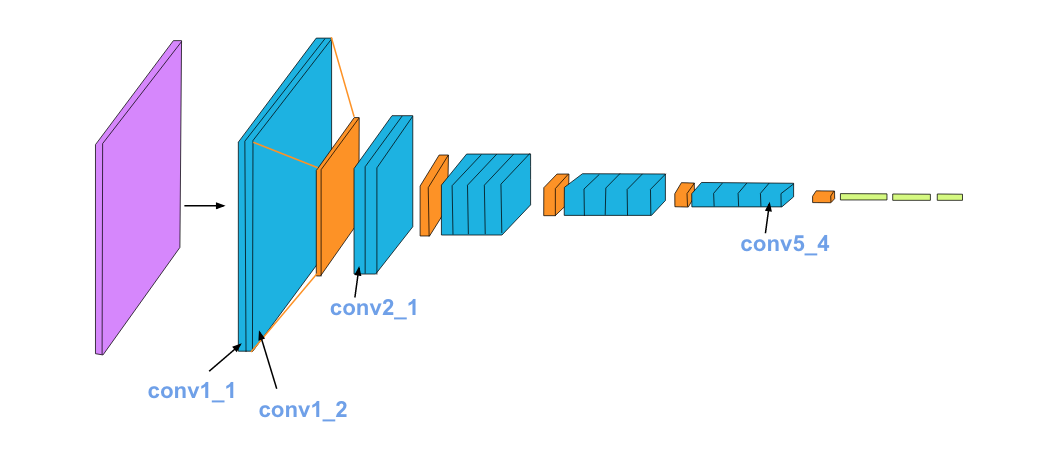

# Separating Style and Content
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, *target image* which should contain our desired content and style components:

-> objects and their arrangement are similar to that of the ***content image***
-> style, colors, and textures are similar to that of the ***style image***
An example is shown below, where the content image is of a cat, and the style image is of Hokusai's Great Wave. The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!
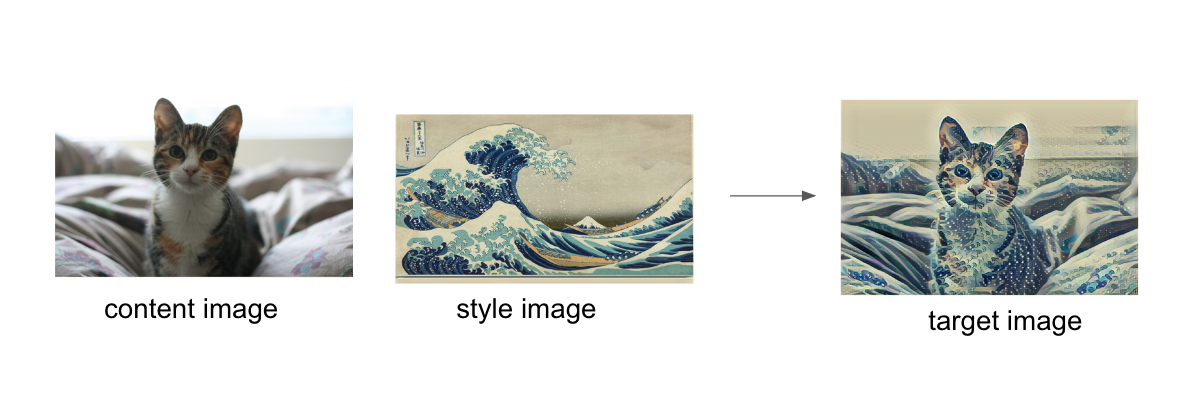

we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style losses and use those to iteratively update our target image until we get a result that we want.

In [ ]:
# import resources
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

# Load in VGG19 (features)
VGG19 is split into two portions:

*   ```vgg19.features```, which are all the convolutional and pooling layers
*   ```vgg19.classifier```, which are the three linear, classifier layers at the end

We only need the ```features``` portion, which we're going to load in and "freeze" the weights of, below. We don't need ```classifier``` portion because here we are trying to extract information and combine it to produce a new image.

In [ ]:
# get the 'features' portion of VGG19 ('classifer' portion is not needed)
# VGG --> Visual Geometry Group
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters (weights, etc) since we're only
# optimizing the target image.
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 86.2MB/s]


In [ ]:
# moving the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Load in Content and Style Images
First a helper function for loading in any type and size of image is made. The ```load_image``` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
        is <= 400 pixels in the x-y dimensions.'''

    # if an image path from the internet is used
    if 'http' in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')

    # if image is uploaded directly
    else:
        image = Image.open(img_path).convert('RGB')

    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    # shape of image
    if shape is not None:
        size = shape

    internal_transform = transforms.Compose([
                            transforms.Resize(size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406),
                                                 (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) & add the batch dimension
    image = internal_transform(image)[:3, :, :].unsqueeze(0)

    return image

forcing the style image to be the same size as the content image

In [ ]:
# load in content and style image
content = load_image('/content/1128087.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('https://miro.medium.com/v2/resize:fit:720/format:webp/1*fpmWsIFOXG3lCVxMCqp2mw.png', shape=content.shape[-2:]).to(device)

In [ ]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

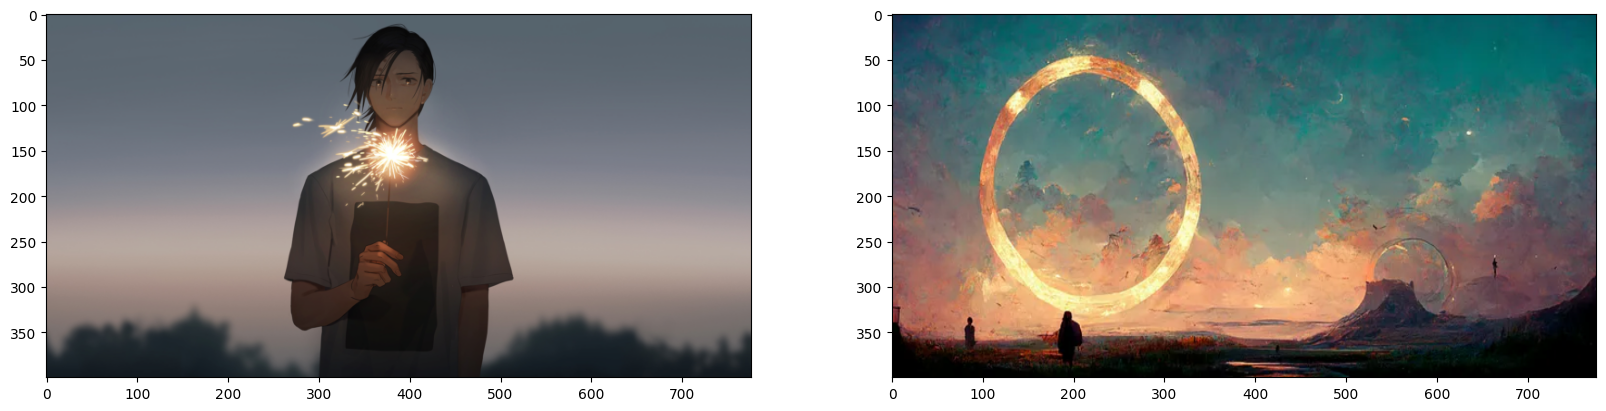

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


# VGG19 Layers
To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [ ]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Content & Style Features

This function has a for loop that iterates over the layers of the VGG19 model. The variable `name` holds the name of the layer and `layer` holds the layer itself. The input image is passed through each layer and the output is stored in variable `x`. If the name of the layer is in the dictionary `layers`, then the output of that layer is stored in a dictionary called `features` with the key being the name of the layer. Finally, this dictionary is returned as output from this function.

In [ ]:
def get_features(image, model, layers=None):
    '''
    Run an image forward through the model and get the features for
    a set of layers.
    '''
    # let's map layer names of pytorch's VGGNet since we need
    # layers for content and style representation.
    if layers is None:
        layers = {
            # -- style representation layers used are -- #
                  '0': 'conv1_1',   # 1st stack, 1st layer
                  '5': 'conv2_1',   # 2nd stack, 1st layer,
                  '10': 'conv3_1',  # 3rd stack, 1st layer,
                  '19': 'conv4_1',  # 4th stack, 1st layer,
                  '28': 'conv5_1',   # 5th stack, 1st layer,

            # -- content representation layers used are --#
                  '21': 'conv4_2'
                  }

    features = {}
    x = image
    # model._modules is a dict holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

We find that matching the style representations
up to higher layers in the network preserves local image structures on increasingly large scale, leading to a smoother and more continuous visual experience. Thus, the visually most appealing images are usually created by matching the **style representation up to high layers in the network**, we match the style features in layers `conv1_1`, `conv2_1`, `conv3_1`,`conv4_1` and `conv5_1` of the network.

different content feature layers that can be used are `Conv2_2`, `Conv4_2`

**Effects:**
* Matching the content on **lower** layer `conv2_2` preserves much of the fine structure of the original photograph and the synthesised image looks as if the texture of the painting is simply blended over the photograph.

* Matching the content on **higher** layer `conv4_2` the texture of the painting and the content of the photograph merge together such that the content of the photograph is displayed in the style of the painting.

weight parameters i.e., ratio of loss values to be added to content loss and style loss (α/β = 1 × 10−3 ).



# Gram Matrix
The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width `(h, w)` i.e., `[batch_size, d, h, w]`. The Gram matrix of a convolutional layer can be calculated as follows:

* Get the `depth`, `height`, and `width` of a tensor using `batch_size, d, h, w = tensor.size()`.
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose i.e., matrix multiplication with the transpose to generate a square matrix (Gram matrix)

Note: Gram matrix should only be calculated for layers used to extract style feature.

In [ ]:
def gram_matrix(tensor):
    '''
    Calc the gram matrix of the given tensor.
    '''

    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    # i.e., d - rows and (h*w) - columns
    tensor = tensor.view(d, h*w)

    # cal the G matrix by multiplying tensor with it's trnaspose
    gram = torch.mm(tensor, tensor.t())

    return gram

# **Putting it all Together**
Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# i.e., gradients should be updatable
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
content_features = get_features(content, vgg, layers={'21': 'conv4_2'})

# ***note:***
some might get a doubt as to why layers dictionary has both style layers and content layers? the answer is simple, when we calculate the loss of the target image with the content and style image's values we need those layers to be present in target image as well. or else it's not possible to calculate loss easily.

# **Loss and Weights**
# Individual Layer Style Weights
By weighting earlier layers (conv1_1 and conv2_1) more, you can expect to get larger style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

# Content and Style Weight
This α/β ratio will affect how stylized your final image is. It's recommended that you leave the α = 1 and set the β to achieve the ratio you want.

In [ ]:
#-------------------------#
# changeable #
#-------------------------#

# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Updating the Target & Calculating Losses
You'll decide on a number of steps for which to update your image, only we are changing our target image and nothing else about VGG19 or any other image.
Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

**Content Loss**
* The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows:

```python
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```
**Style Loss**
* The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary style_weights.
* calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. Later, you'll see that this value is normalized by the size of the layer.

**Total Loss**

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Focus on the appearance of your target image rather than any loss value.

In [ ]:
# content_loss function
def content_loss_func(target_conv_4_2, content_conv_4_2):
  loss = torch.mean((target_conv_4_2-content_conv_4_2)**2)
  return loss


In [ ]:
# style_loss function
def style_loss_func(style_weights,target_features,style_grams):
    # first initialize style loss to 0
    style_loss = 0
    # iterate through each style layer and then add the style loss
    for layer in style_weights:

        # get the `target` style representation for one layer
        # calculate the target gram matrix
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape # for normalizing

        # get the `style` style represntation
        style_gram = style_grams[layer]

        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

         # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

        return style_loss

Total loss:  907376.125


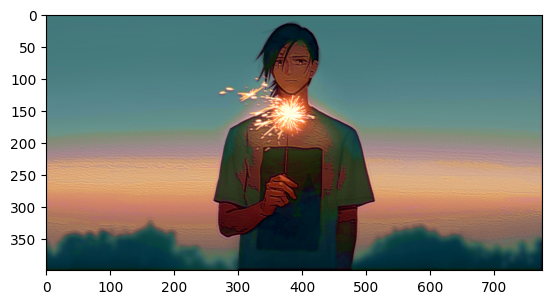

Total loss:  262032.296875


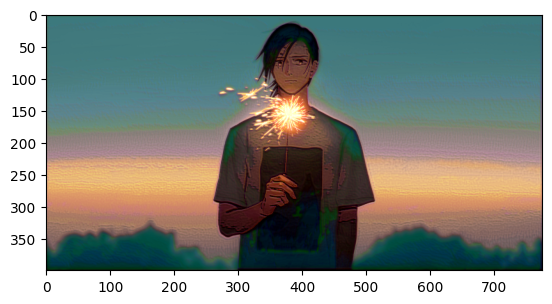

Total loss:  82989.0546875


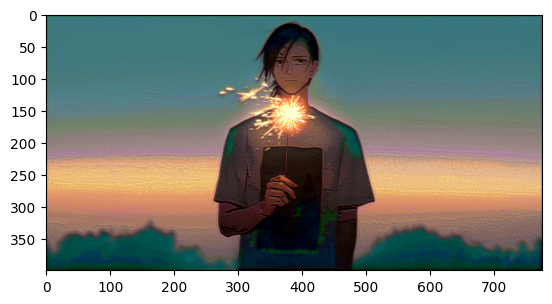

Total loss:  37972.16015625


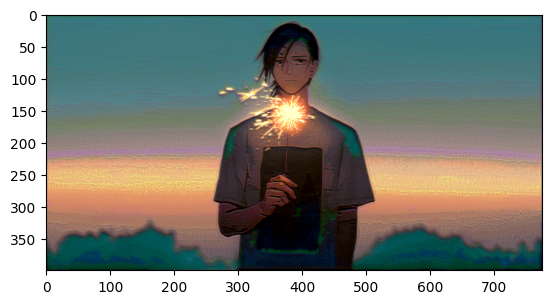

Total loss:  22498.66015625


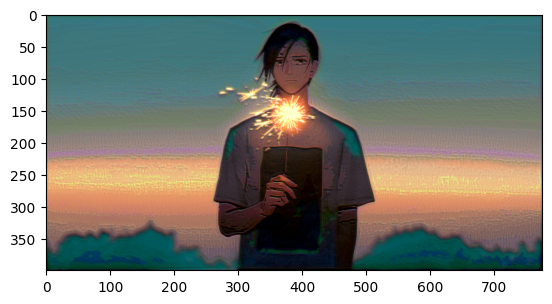

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000 # decide how many iterations to update target image

for ii in range(1, steps+1):

    # getting features from the target image through vgg
    target_features = get_features(target, vgg)
    # calc content loss
    content_loss =  content_loss_func(target_features['conv4_2'],content_features['conv4_2'])

    # cal style loss
    style_loss = style_loss_func(style_weights, target_features , style_grams)

    # calculate the `total` loss
    total_loss = content_weight*content_loss + style_weight*style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
print(target_features.keys())

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


In [ ]:
print(content_features.keys())

dict_keys(['conv4_2'])


# Display the Target Image


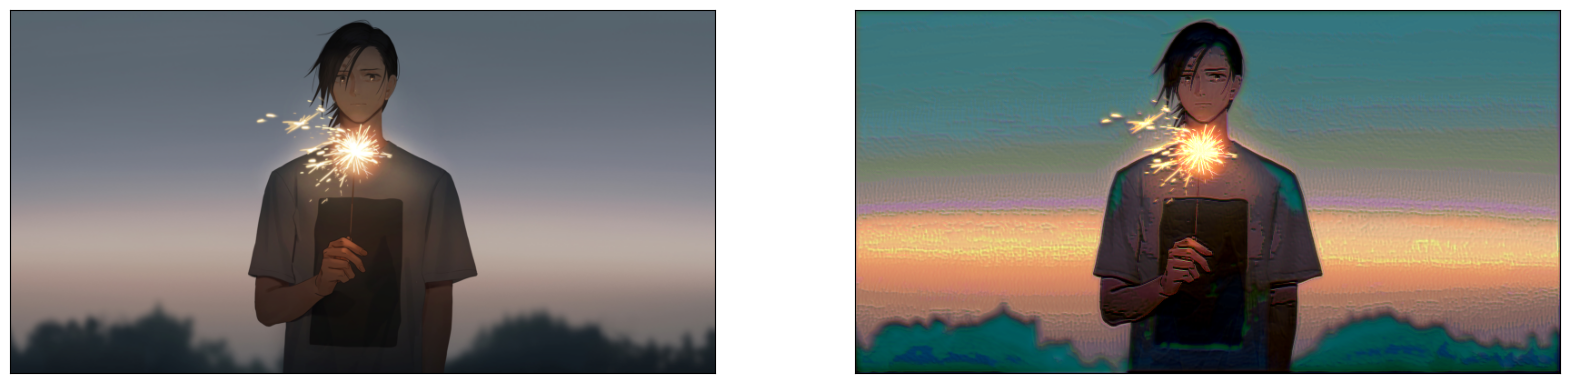

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)